## Project 2. Part 2 (Explore, Clean & Model)

In [2217]:
import re
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from diagnostic_plots import diagnostic_plots

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
%matplotlib inline

### Define some useful functions

In [2218]:
#To clean the engine_size column (convert into floats)
def clean_engine(series):
    """Takes a series of strings and converts them into floats where possible.
    Returns a list of floats."""
    values = car_ad_dataset['Engine_Size']
    new_values = []
    for value in values:
        try:
            val = float(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the price column
def clean_price(series):
    """Takes a series of strings, cleans them from text and converts them into floats where possible.
    Returns a list of floats."""
    values = series.str.split('€').str[0]
    new_values = []
    for value in values:
        try:
            val = float(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the mileage column
def clean_kms(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('km').str[0]
    new_values = []
    for value in values:
        try:
            val = int(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the Number of Doors column
def clean_door_count(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('/').str[0]
    new_values = []
    for value in values:
        try:
            val = int(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Convert 'Fuel type' to numeric value (Petrol = 0, Diesel = 1) !If the car is electric, it assigns NaN
def fuel_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Petrol and 1 for Diesel.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Petrol' or value == 'Petrol / LPG':
            val = int(0)
            new_values.append(val)
        elif value == 'Diesel' or value == 'Diesel / gas':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def gearbox_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Manual and 1 for Automatic.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Manual':
            val = int(0)
            new_values.append(val)
        elif value == 'Automatic':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def white_colour(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-White and 1 for White.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'White':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def red_colour(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-Red and 1 for Red.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Red':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def group_body_types(series):
    """Takes a series of body types and groups them to categories.
    Returns a list of tuples."""
    body_type_dict = {'Other': ('Other', 'Limousine'), 'Limousine':('Other', 'Limousine'), 'Coupe':('Coupe'), 'Hatchback':('Hatchback'), 'Saloon / sedan':('Saloon / sedan', 'Convertible'), 'Convertible':('Saloon / sedan', 'Convertible'), 'Wagon':('Wagon'), 'SUV / off-road':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'MPV / minivan':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Commercial':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Pick-up':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up')}
    values = series
    new_values = []
    for value in values:
        val = body_type_dict[value]
        new_values.append(val)
    return new_values
    
def numeric_body_type(series):
    """Takes a series of body types and converts them into numbers from smallest to largest.
    Returns a list of integers"""
    body_types = {('Other', 'Limousine'):np.NaN, ('Coupe'):2, ('Hatchback'):3, ('Saloon / sedan', 'Convertible'):4, ('Wagon'):5, ('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'):6}
    values = series
    new_values = []
    for value in values:
        try:
            val = body_types[value]
            new_values.append(val)
        except:
            val = np.NaN
            new_values.append(val)
    return new_values

### Unpickle the file

In [2219]:
with open('car_ad_dataset.pkl', 'rb') as picklefile:
    car_ad_dataset = pickle.load(picklefile)
    
#Verify that the result is as desired
car_ad_dataset.head()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
0,"CD player,AUX input,Navigation/GPS,Handsfree kit",Wagon,Climate control,Black,NaN,No damages,2018-02,All wheel (4х4),"Electric mirrors,Electric boot lid,Galinio vai...","1995 cm³, 190 HP (139kW)",...,"Not exploited in Lithuania,Available for leasi...",44 900 €,"ABS,Traction control system,ESP iElectronic st...","Central locking,Immobilizer,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
1,NaN,Coupe,None,Blue,NaN,No damages,1992,Rear wheel drive (RWD),Electric windows,"1998 cm³, 156 HP (115kW)",...,NaN,4 400 €\n \n Sužinokite įmoką\n ...,NaN,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,R17
2,"CD player,MP3 player,Original audio system,USB...",Hatchback,NaN,NaN,NaN,No damages,2010-03,NaN,Electric windows,"1400 cm³, 89 HP (66kW)",...,Service book,5 500 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...","Central locking,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
3,"CD player,AUX input,Navigation/GPS,USB input,H...",SUV / off-road,NaN,NaN,NaN,No damages,2013-03,NaN,"Electric mirrors,Galinio vaizdo kamera,In-car ...","2200 cm³, 175 HP (129kW)",...,"Not exploited in Lithuania,Available for leasi...",12 700 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...",NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
4,Navigation/GPS,SUV / off-road,NaN,NaN,NaN,Crashed,2009-03,NaN,"Electric windows,Cruise control",4800 cm³,...,Not exploited in Lithuania,4 999 €\n \n Sužinokite įmoką\n ...,Airbags,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN


In [2220]:
#Check out the shape and get info
print('The shape is:', str(car_ad_dataset.shape), '\n');
car_ad_dataset.info()

The shape is: (3020, 35) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 35 columns):
Audio/video equipment         995 non-null object
Body type                     1498 non-null object
Climate control               894 non-null object
Color                         1205 non-null object
Combined                      618 non-null object
Damage                        1498 non-null object
Date of manufacture           1498 non-null object
Driven wheels                 1098 non-null object
Electronics                   1243 non-null object
Engine                        1475 non-null object
Engine_Size                   1498 non-null object
Euro standard                 475 non-null object
Export price                  376 non-null object
Exterior                      1218 non-null object
Extra-urban                   617 non-null object
First registration country    703 non-null object
Fuel type                     1498 non-null object
Gearbo

In [2221]:
car_ad_dataset.describe()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
count,995,1498,894,1205,618,1498,1498,1098,1243,1475,...,909,1498,1146,907,1498,66,607,1493,196,782
unique,363,11,3,11,90,6,328,3,443,694,...,60,479,83,13,2,13,114,2,195,10
top,"CD player,Original audio system",Saloon / sedan,Climate control,Gray / silver,6.00,No damages,2005,Front wheel drive (FWD),"Electric windows,Cruise control","1968 cm³, 140 HP (103kW)",...,"Not exploited in Lithuania,Service book,Cataly...",650 €\n \n Sužinokite įmoką\n ...,Airbags,"Central locking,Immobilizer,Alarm",Left hand drive (LHD),Increased engine power,7.00,\n \n Check vehicle history\...,WBAUG31040PU49618,R16
freq,113,370,652,416,42,1394,25,696,156,35,...,123,51,293,249,1479,22,32,1297,2,218


In [2222]:
#Explore the dataset
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       1498
Price in Lithuania            1498
Fuel type                     1498
Make_Model                    1498
Number of doors               1498
Date of manufacture           1498
Engine_Size                   1498
Damage                        1498
Steering wheel                1498
Body type                     1498
VIN check                     1493
Engine                        1475
Interior                      1258
Electronics                   1243
Exterior                      1218
Color                         1205
Mileage                       1157
Safety                        1146
Driven wheels                 1098
Number of seats               1036
Audio/video equipment          995
Other features                 909
Security                       907
Climate control                894
Wheel size                     782
MOT test expiry                773
First registration country     703
Combined                       618
Extra-urban         

### Clean the dataset

**Initial cleaning and formatting**

In [2223]:
#Clean up the price column and convert to a float
car_ad_dataset['Price'] = clean_price(car_ad_dataset['Price in Lithuania'])

In [2224]:
#Split the Make_Model column
car_ad_dataset['Make'], car_ad_dataset['Model'] = car_ad_dataset['Make_Model'].str.split(' ', 1).str

In [2225]:
#Clean up the Engine_Size column from l.
car_ad_dataset['Engine_Size'] = car_ad_dataset['Engine_Size'].str.split(' ', 2).str[1]
car_ad_dataset['Engine_Size_l'] = clean_engine(car_ad_dataset['Engine_Size'])

In [2226]:
#Clean the Engine column
#Some of the cars don't have the cm3, so instead this takes HP or kW, will have to drop those later on!!!
car_ad_dataset['Engine_cm3'] = pd.to_numeric(car_ad_dataset['Engine'].str.split(' ').str[0])

In [2227]:
#Only keep the Year of manufacture
car_ad_dataset['Year_of_manufacture'] = pd.to_numeric(car_ad_dataset['Date of manufacture'].str[:4])

In [2228]:
#Clean up the milage column to remove 'km'
car_ad_dataset['Mileage_km'] = clean_kms(car_ad_dataset['Mileage'])

In [2229]:
#Clean up the number of doors to remove /second number
car_ad_dataset['Door_count'] = clean_door_count(car_ad_dataset['Number of doors'])

In [2230]:
#Convert Fuel type column to boolean (0,1)
car_ad_dataset['Fuel type'] = fuel_bool(car_ad_dataset['Fuel type'])

In [2231]:
car_ad_dataset['Gearbox'] = gearbox_bool(car_ad_dataset['Gearbox'])
#car_ad_dataset['Gearbox']

In [2232]:
car_ad_dataset['White_colour'] = white_colour(car_ad_dataset['Color'])
#car_ad_dataset['Gearbox']

In [2233]:
car_ad_dataset['Red_colour'] = red_colour(car_ad_dataset['Color'])
#car_ad_dataset['Gearbox']

In [2234]:
#Rename the Fuel type column
car_ad_dataset = car_ad_dataset.rename(columns = {'Fuel type': 'Fuel_type'})

In [2235]:
#Remove cars that are damaged
car_ad_dataset = car_ad_dataset[car_ad_dataset['Damage'] == 'No damages']
car_ad_dataset.drop(columns = ['Damage'], inplace = True)

#Remove cars that are not Left hand drive
car_ad_dataset = car_ad_dataset[car_ad_dataset['Steering wheel'] == 'Left hand drive (LHD)']
car_ad_dataset.drop(columns = ['Steering wheel'], inplace = True)

#car_ad_dataset.head()

In [2236]:
#Generalize body types
car_ad_dataset['Body_type_group'] = group_body_types(car_ad_dataset['Body type'])
car_ad_dataset['Body_type'] = numeric_body_type(car_ad_dataset['Body_type_group'])

In [2237]:
#Sanity check (values in fuel type)
car_ad_dataset['Make'].value_counts()

BMW              186
Volkswagen       167
Audi             158
Opel             104
Mercedes-Benz     97
Toyota            95
Volvo             74
Ford              50
Renault           49
Peugeot           49
Citroen           39
Nissan            32
Mazda             29
Skoda             26
Hyundai           19
Lexus             17
Honda             16
Fiat              16
Mitsubishi        16
Chrysler          15
Seat              14
Subaru            12
Kia               12
Chevrolet         11
Alfa              10
Mini               8
Saab               8
Rover              5
Jaguar             4
Smart              4
Land               4
Jeep               4
Suzuki             3
Infiniti           3
Dodge              3
ZAZ                2
Lada               2
Porsche            2
Daewoo             1
SsangYong          1
UAZ                1
Moskvich           1
GAZ                1
Cadillac           1
-Kita-             1
Lancia             1
Proton             1
Dacia        

In [2238]:
#Sanity check (values in fuel type)
#car_ad_dataset['Body type'].value_counts()

**Shorten the dataset & re-evaluate**

In [2239]:
#Shorten the dataset by picking the most logical features
short_car_ad_dataset = car_ad_dataset[['Make', 'Body_type', 'Year_of_manufacture', 'Engine_Size_l', 'Fuel_type', 'Gearbox', 'Mileage_km','Door_count', 'White_colour', 'Red_colour', 'Price']]
short_car_ad_dataset.head()

,Make,Body_type,Year_of_manufacture,Engine_Size_l,Fuel_type,Gearbox,Mileage_km,Door_count,White_colour,Red_colour,Price
0,BMW,5.0,2018.0,2.0,1.0,1.0,8100.0,4.0,0,0,44900.0
1,Toyota,2.0,1992.0,2.0,0.0,0.0,270000.0,2.0,0,0,4400.0
2,Toyota,3.0,2010.0,1.4,1.0,0.0,161800.0,4.0,0,0,5500.0
3,Mazda,6.0,2013.0,2.2,1.0,1.0,208000.0,4.0,0,0,12700.0
6,Mazda,4.0,2009.0,2.5,0.0,1.0,144000.0,4.0,0,0,4999.0


In [2240]:
#Get the info on the shorten dataset
short_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 2987
Data columns (total 11 columns):
Make                   1376 non-null object
Body_type              1364 non-null float64
Year_of_manufacture    1376 non-null float64
Engine_Size_l          1329 non-null float64
Fuel_type              1356 non-null float64
Gearbox                1376 non-null float64
Mileage_km             1070 non-null float64
Door_count             1369 non-null float64
White_colour           1376 non-null int64
Red_colour             1376 non-null int64
Price                  1376 non-null float64
dtypes: float64(8), int64(2), object(1)
memory usage: 129.0+ KB


**Clean the small dataset of NaN values**

In [2241]:
#Drop all the cars that are missing at least one of the values
clean_car_ad_dataset = short_car_ad_dataset.dropna(how = 'any')

#And review again
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 0 to 2987
Data columns (total 11 columns):
Make                   1015 non-null object
Body_type              1015 non-null float64
Year_of_manufacture    1015 non-null float64
Engine_Size_l          1015 non-null float64
Fuel_type              1015 non-null float64
Gearbox                1015 non-null float64
Mileage_km             1015 non-null float64
Door_count             1015 non-null float64
White_colour           1015 non-null int64
Red_colour             1015 non-null int64
Price                  1015 non-null float64
dtypes: float64(8), int64(2), object(1)
memory usage: 95.2+ KB


In [2242]:
#Let's have a look again
clean_car_ad_dataset.head()

,Make,Body_type,Year_of_manufacture,Engine_Size_l,Fuel_type,Gearbox,Mileage_km,Door_count,White_colour,Red_colour,Price
0,BMW,5.0,2018.0,2.0,1.0,1.0,8100.0,4.0,0,0,44900.0
1,Toyota,2.0,1992.0,2.0,0.0,0.0,270000.0,2.0,0,0,4400.0
2,Toyota,3.0,2010.0,1.4,1.0,0.0,161800.0,4.0,0,0,5500.0
3,Mazda,6.0,2013.0,2.2,1.0,1.0,208000.0,4.0,0,0,12700.0
6,Mazda,4.0,2009.0,2.5,0.0,1.0,144000.0,4.0,0,0,4999.0


In [2243]:
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 0 to 2987
Data columns (total 11 columns):
Make                   1015 non-null object
Body_type              1015 non-null float64
Year_of_manufacture    1015 non-null float64
Engine_Size_l          1015 non-null float64
Fuel_type              1015 non-null float64
Gearbox                1015 non-null float64
Mileage_km             1015 non-null float64
Door_count             1015 non-null float64
White_colour           1015 non-null int64
Red_colour             1015 non-null int64
Price                  1015 non-null float64
dtypes: float64(8), int64(2), object(1)
memory usage: 95.2+ KB


**Explore target variable**

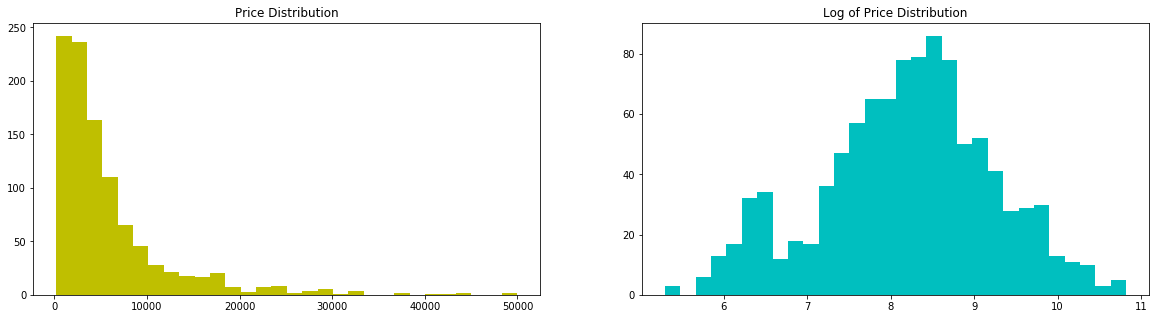

In [2244]:
#Plot Price histogram (to check the distribution)
fig = plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.hist(clean_car_ad_dataset['Price'], bins=30, color = 'y')
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
plt.hist(np.log(clean_car_ad_dataset['Price']), bins=30, color = 'c')
plt.title('Log of Price Distribution')
plt.show()

**Explore the features**

Text(0.5,1,'Door count')

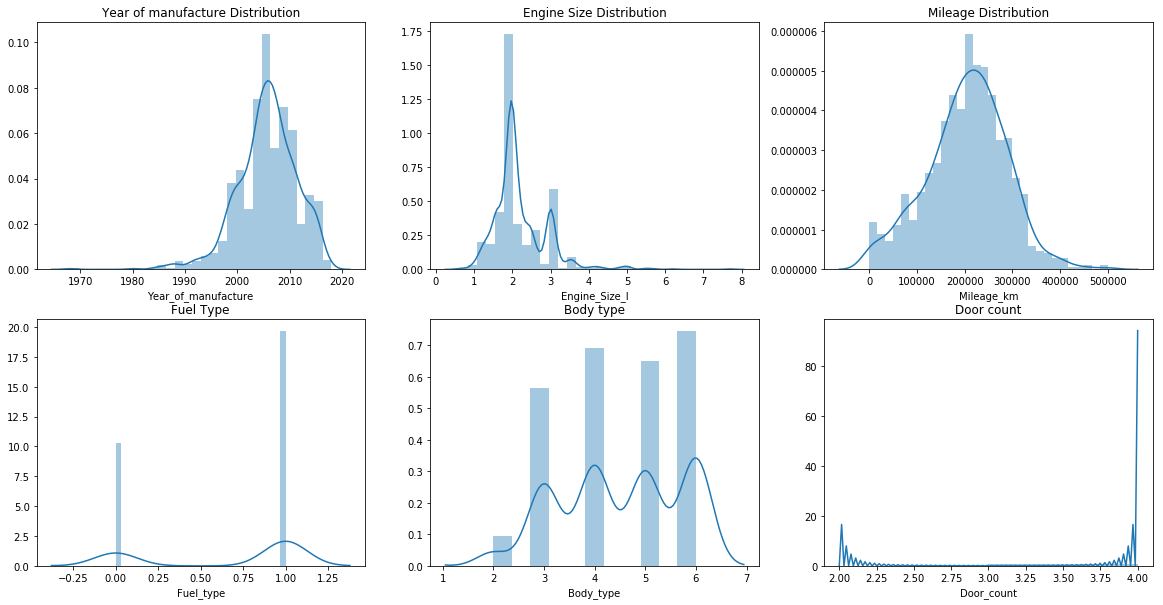

In [2260]:
#Create a 2 x 3 plot matrix
fig = plt.figure(figsize = (20, 10))

#Distribution of years
plt.subplot(2, 3, 1)
sns.distplot(clean_car_ad_dataset["Year_of_manufacture"], bins = 30); 
plt.title('Year of manufacture Distribution')

#Distribution of Engine Size 
plt.subplot(2, 3, 2)
sns.distplot(clean_car_ad_dataset["Engine_Size_l"], bins = 30); 
plt.title('Engine Size Distribution')

#Distribution of Mileage 
plt.subplot(2, 3, 3)
sns.distplot(clean_car_ad_dataset["Mileage_km"], bins = 30); 
plt.title('Mileage Distribution')

#Distribution of Fuel Type
plt.subplot(2, 3, 4)
sns.distplot(clean_car_ad_dataset["Fuel_type"], bins = 30); 
plt.title('Fuel Type')

#Distribution of Body Type
plt.subplot(2, 3, 5)
sns.distplot(clean_car_ad_dataset["Body_type"]); 
plt.title('Body type')

#Distribution of Door count
plt.subplot(2, 3, 6)
sns.distplot(clean_car_ad_dataset["Door_count"], bins = 2); 
plt.title('Door count')

Text(0.5,1,'Mileage Distribution')

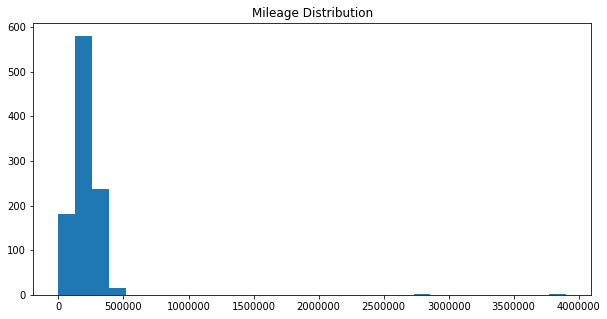

In [2246]:
#Plot Mileage histogram (to check the distribution)
plt.figure(figsize = (10, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution')


In [2247]:
#Checked Milage outliers
#clean_car_ad_dataset[clean_car_ad_dataset['Mileage_km'] >= 1000000.0]
clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Mileage_km'] <= 1000000.0]
#clean_car_ad_dataset.head()

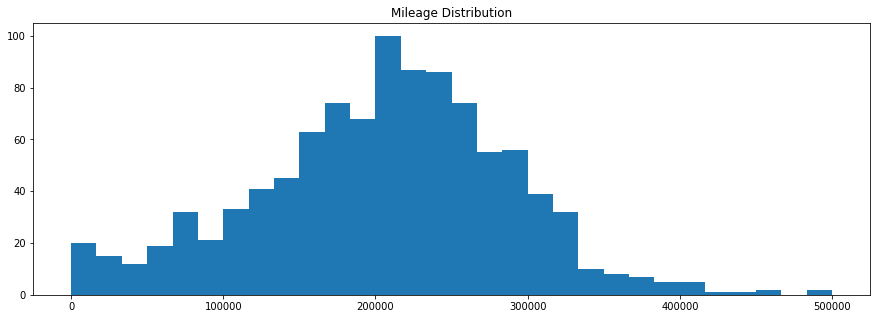

In [2248]:
#Let's plot Mileage histogram again, after removing outliers (to check the distribution)
plt.figure(figsize = (15, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution');

### Let's try modelling

In [2249]:
#Check the correlation between different variables
clean_car_ad_dataset.corr()

,Body_type,Year_of_manufacture,Engine_Size_l,Fuel_type,Gearbox,Mileage_km,Door_count,White_colour,Red_colour,Price
Body_type,1.000000,0.126547,0.177711,0.241316,0.110107,0.103794,0.412397,0.052673,NaN,0.129678
Year_of_manufacture,0.126547,1.000000,-0.014205,0.131884,0.292090,-0.448676,0.114178,0.128257,NaN,0.608840
Engine_Size_l,0.177711,-0.014205,1.000000,-0.064953,0.517929,0.050364,0.118715,0.014911,NaN,0.347059
Fuel_type,0.241316,0.131884,-0.064953,1.000000,-0.127039,0.307899,0.149309,-0.044867,NaN,-0.050137
Gearbox,0.110107,0.292090,0.517929,-0.127039,1.000000,-0.161584,0.080083,0.031137,NaN,0.465711
Mileage_km,0.103794,-0.448676,0.050364,0.307899,-0.161584,1.000000,0.097116,-0.081481,NaN,-0.450056
Door_count,0.412397,0.114178,0.118715,0.149309,0.080083,0.097116,1.000000,-0.008965,NaN,0.063402
White_colour,0.052673,0.128257,0.014911,-0.044867,0.031137,-0.081481,-0.008965,1.000000,NaN,0.145361
Red_colour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,0.129678,0.608840,0.347059,-0.050137,0.465711,-0.450056,0.063402,0.145361,NaN,1.000000


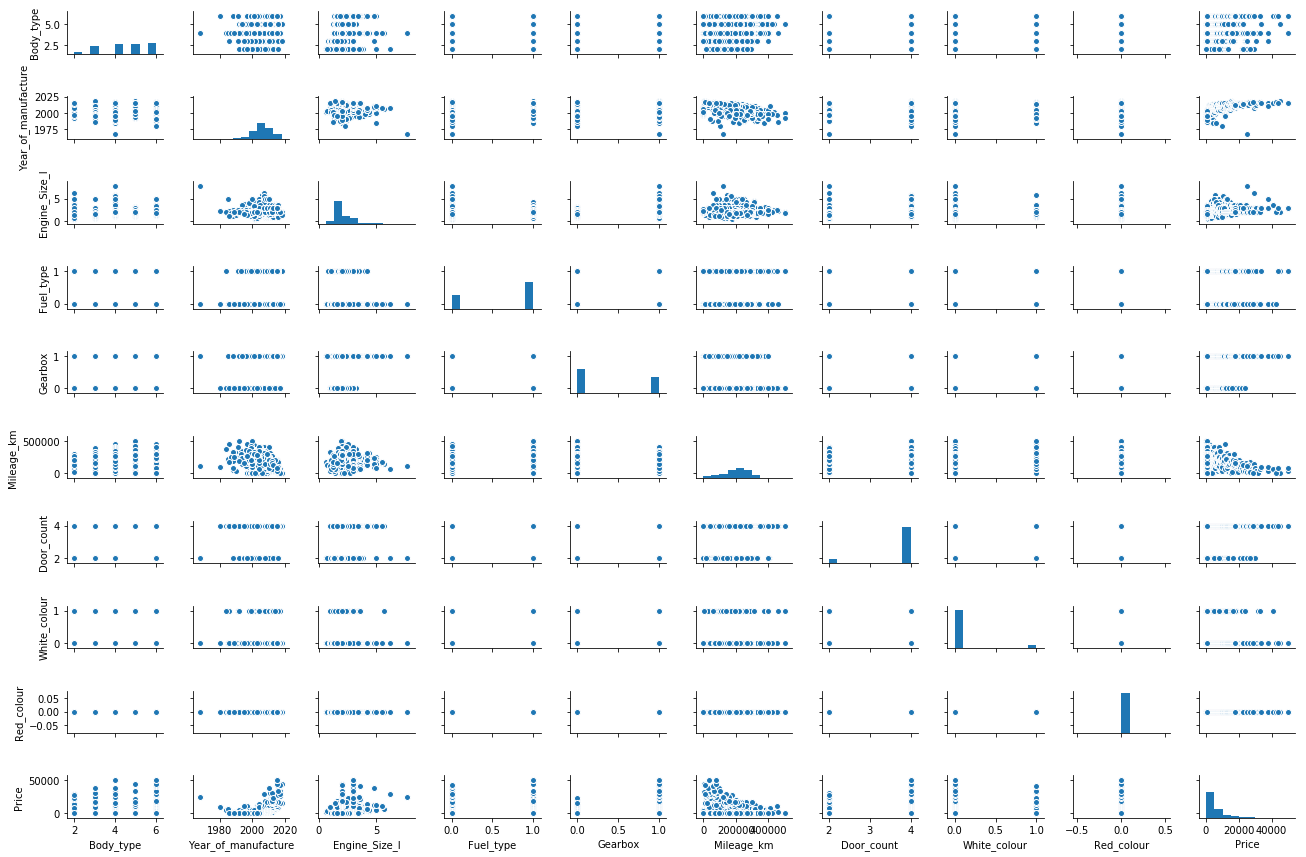

In [2250]:
#Visualize the correlations
sns.pairplot(clean_car_ad_dataset, size = 1.2, aspect=1.5);

**Statsmodels way**

In [2251]:
#Create the target vector and feature matrix
y, X = patsy.dmatrices('np.log(Price) ~ Year_of_manufacture + Engine_Size_l + Mileage_km + Fuel_type + Gearbox', clean_car_ad_dataset)

#Linear Regression
car_ad_model = sm.OLS(y, X)

**Sklearn way**

In [2252]:
#Create the feature matrix and target vector
X, y = clean_car_ad_dataset[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox']], clean_car_ad_dataset['Price']

In [2253]:
#Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [2254]:
car_ad_model_fit = car_ad_model.fit()
car_ad_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     622.4
Date:                Fri, 13 Jul 2018   Prob (F-statistic):          5.31e-305
Time:                        16:43:34   Log-Likelihood:                -754.75
No. Observations:                1013   AIC:                             1522.
Df Residuals:                    1007   BIC:                             1551.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -239.9995      7.094    -33.829      0.000    -253.921    -226.078
Year_of_manufacture     0.1232      0.004     34.930      0.000       0.116       0.130
Engine_Size_l           0.5023      0.027     18.286      0.000       0.448       0.556
Mileage_km          -1.248e-06   2.37e-07     -5.263      0.000   -1.71e-06   -7.83e-07
Fuel_type               0.1353      0.038      3.551      0.000       0.061       0.210
Gearbox                 0.2579      0.042      6.207      0.000       0.176       0.340
==============================================================================
Omnibus:                      321.079   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3895.367
Skew:                           1.094   Prob(JB):                         0.00
Kurtosis:                      12.354   Cond. No.                     9.76e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.76e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KeyError: 917

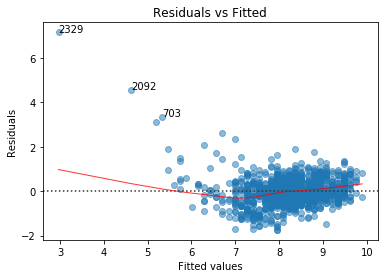

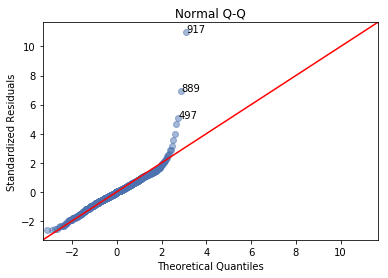

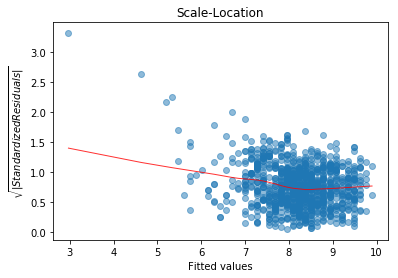

In [2255]:
# Use diagnostic_plots python file to plot Year of manufacture results
diagnostic_plots(clean_car_ad_dataset['Year_of_manufacture'], np.log(clean_car_ad_dataset['Price']));


In [ ]:
# Use diagnostic_plots python file to plot Engine Size (l) results
diagnostic_plots(clean_car_ad_dataset['Engine_Size_l'], clean_car_ad_dataset['Price'])

In [ ]:
# Use diagnostic_plots python file to plot Mileage (km) results
diagnostic_plots(clean_car_ad_dataset['Mileage_km'], clean_car_ad_dataset['Price'])

In [ ]:
# Use diagnostic_plots python file to plot Fuel type results
diagnostic_plots(clean_car_ad_dataset['Fuel_type'], clean_car_ad_dataset['Price'])

In [ ]:
# Use diagnostic_plots python file to plot Fuel type results
diagnostic_plots(clean_car_ad_dataset['Gearbox'], clean_car_ad_dataset['Price'])